In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
import warnings
warnings.filterwarnings("ignore")

from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [16]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv', index_col=0)

In [17]:
df.head()

statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety

In [18]:
df.describe()

statement  status
count               52681   53043
unique              51073       7
top     what do you mean?  Normal
freq                   22   16351

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


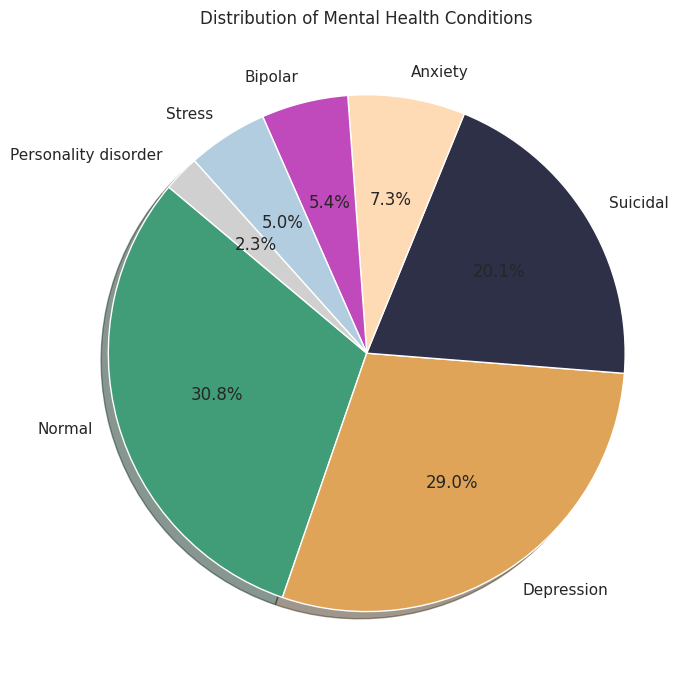

In [20]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

In [21]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: College Student w/ Anxiety: Dating Life I first developed severe anxiety and panic disorder in my senior year of high school. I can proudly say that with perseverance, proper medication, and the help of my lovely therapist, family, and friends, I was able to complete my senior year and begin college in the fall. I’ve taken a liking to this guy in my class, and we will hang out this weekend. I am very inexperienced in the dating world as I’ve only really gone out with three guys ever… none of which lasted more than a few months. Though I had not been diagnosed with anxiety in my sophomore year of high school, I began dating this guy whom I was pretty infatuated with. However, the first time he put his arm around me, I shook uncontrollably. I misread that as a sign that he wasn’t suitable for me when it was just anxiety. Fast forward to now, I am anxious about seeing this guy this weekend, and I am scared that these feelings of fear won’t go away even if we con

In [45]:
import nltk
nltk.download('punkt_tab')
# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


       num_of_characters  num_of_sentences
count       53043.000000      53043.000000
mean          560.139359          0.999906
std           825.243325          0.009709
min             0.000000          0.000000
25%            74.000000          1.000000
50%           304.000000          1.000000
75%           730.000000          1.000000
max         31499.000000          1.000000


In [23]:
df[df['num_of_characters'] > 10000]

statement  \
7851   So introduction I guess.. my name is Michael a...   
9416   AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   
9504   Hello everyone,I rarely post on Reddit but.......   
10834  I have only 1 person I can somewhat open to bu...   
11537  The title is not meant to discourage others, b...   
11581  I no longer know what else to do but write thi...   
11636  And has life gotten better?&amp;#x200B;No. Eve...   
11831  Sorry this is long but I doubt anyone will eve...   
13293  I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...   
18215  I am someone living in Turkey. My age is proba...   
21396  will i ever be noticed? is my life worth anyth...   
21858  I constantly repeat to myself that I have neve...   
22243  I do not expect anyone to read this rambly mes...   
22563  I have been thinking about posting online for ...   
23820  I need support or encouragement. I (29M) reall...   
23845  This is a a vent. I (29M) really do not know w...   
39752  it doesn t matter anymore i m going to copy an...   
46660  DEPRESSION HAS A PURPOSE: HOW TO USE IT RIGHT ...   
51396  Please help me understand what I went through ...   

                     status  num_of_characters  
7851             Depression            10679.0  
9416               Suicidal            25302.0  
9504             Depression            11163.0  
10834              Suicidal            27390.0  
11537            Depression            12304.0  
11581            Depression            13530.0  
11636            Depression            12819.0  
11831            Depression            11122.0  
13293              Suicidal            32759.0  
18215              Suicidal            10219.0  
21396            Depression            12298.0  
21858            Depression            13054.0  
22243              Suicidal            12227.0  
22563              Suicidal            12028.0  
23820            Depression            11111.0  
23845              Suicidal            11075.0  
39752            Depression            19822.0  
46660               Bipolar            26163.0  
51396  Personality disorder            27588.0

Text Preprocessing

In [24]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isnull().sum())

# Data sample
df.sample(5, random_state=101)


Shape: (53043, 3)

Columns: ['statement', 'status', 'num_of_characters']

Missing values per column:
 statement            362
status                 0
num_of_characters    362
dtype: int64


statement      status  \
10190  Hi all,Recently, I have felt immense displeasu...  Depression   
29146  I got out of an abusive relationship about thr...      Normal   
7668   I am surrounded by people and yet i feel so lo...    Suicidal   
24292  There are different 'types' of being suicidal,...    Suicidal   
4456   hello, I'm looking for a mutual. all fandom es...      Normal   

       num_of_characters  
10190              567.0  
29146              551.0  
7668               726.0  
24292             2681.0  
4456               118.0

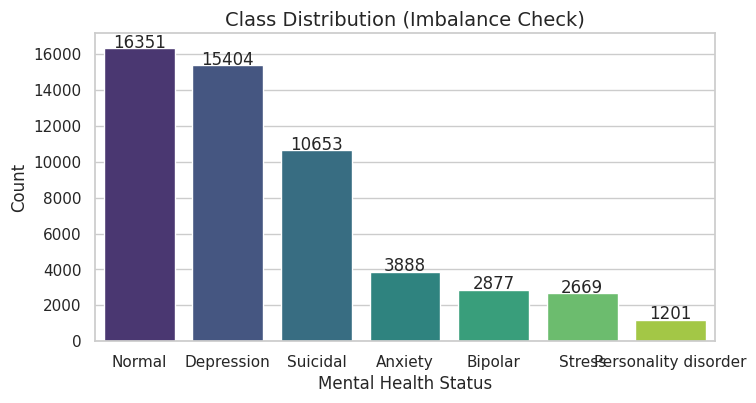

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64 

Class ratio (%):
status
Normal                  30.83
Depression              29.04
Suicidal                20.08
Anxiety                  7.33
Bipolar                  5.42
Stress                   5.03
Personality disorder     2.26
Name: count, dtype: float64


In [25]:
status_counts = df['status'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')
plt.title("Class Distribution (Imbalance Check)", fontsize=14)
plt.ylabel("Count"); plt.xlabel("Mental Health Status")
for i,v in enumerate(status_counts.values):
    plt.text(i, v+20, str(v), ha='center')
plt.show()

print(status_counts, "\n\nClass ratio (%):")
print(round(100 * status_counts / len(df), 2))


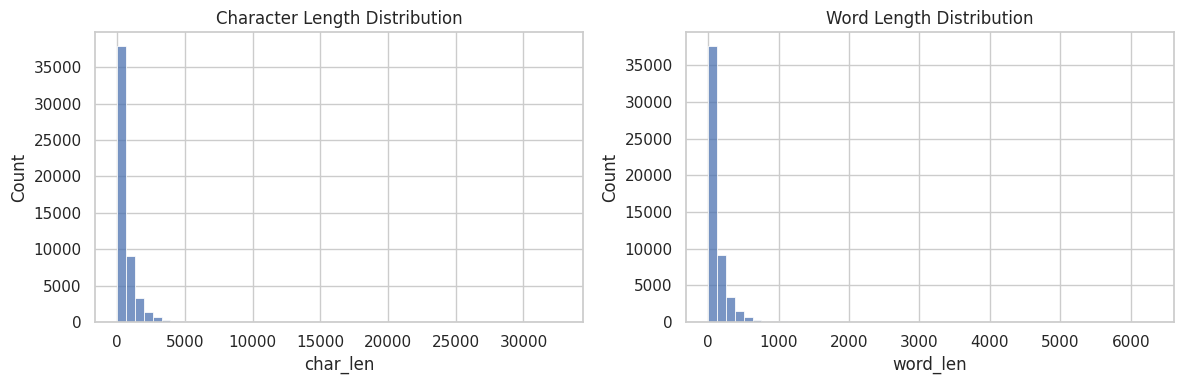

            count        mean         std  min   25%    50%    75%      max
char_len  53043.0  574.784816  844.707198  2.0  77.0  313.0  748.0  32759.0
word_len  53043.0  112.393285  163.436684  1.0  15.0   61.0  147.5   6300.0


In [26]:
# df['char_len'] = df['statement'].apply(len)
# df['word_len'] = df['statement'].apply(lambda x: len(str(x).split()))

# fig, ax = plt.subplots(1,2, figsize=(12,4))
# sns.histplot(df['char_len'], bins=50, ax=ax[0], color='royalblue')
# ax[0].set_title("Character Length Distribution")
# sns.histplot(df['word_len'], bins=50, ax=ax[1], color='seagreen')
# ax[1].set_title("Word Length Distribution")
# plt.show()

# print(df[['char_len','word_len']].describe().T)


# Ensure no NaN values exist in the text column
df['statement'] = df['statement'].astype(str).fillna("")

# Create text length features
df['char_len'] = df['statement'].apply(lambda x: len(str(x)))
df['word_len'] = df['statement'].apply(lambda x: len(str(x).split()))

# Plot distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df['char_len'], bins=50, ax=ax[0])
ax[0].set_title("Character Length Distribution")

sns.histplot(df['word_len'], bins=50, ax=ax[1])
ax[1].set_title("Word Length Distribution")

plt.tight_layout()
plt.show()

# Summary statistics
print(df[['char_len', 'word_len']].describe().T)


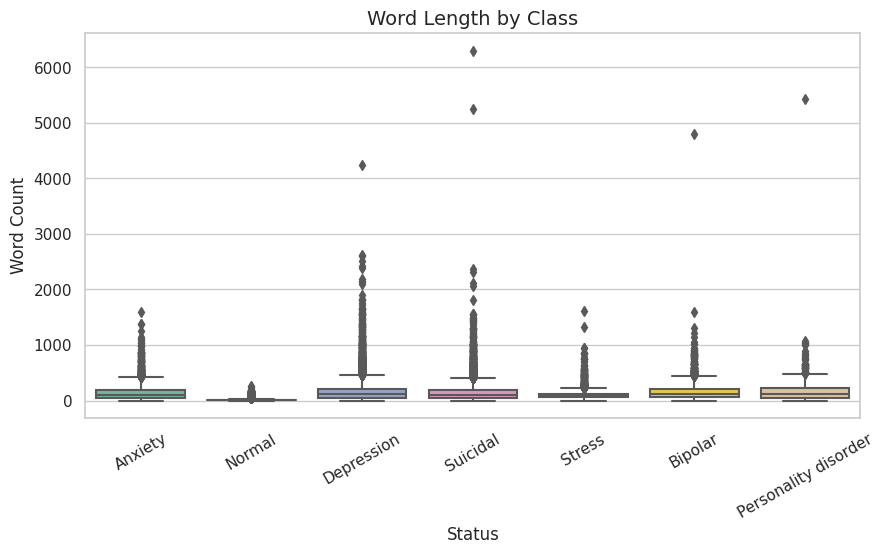

In [27]:
plt.figure(figsize=(10,5))
sns.boxplot(x='status', y='word_len', data=df, palette='Set2')
plt.title("Word Length by Class", fontsize=14)
plt.ylabel("Word Count"); plt.xlabel("Status")
plt.xticks(rotation=30)
plt.show()


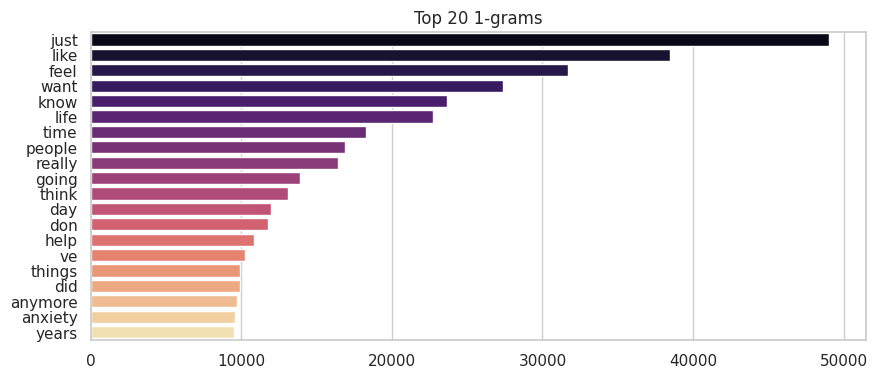

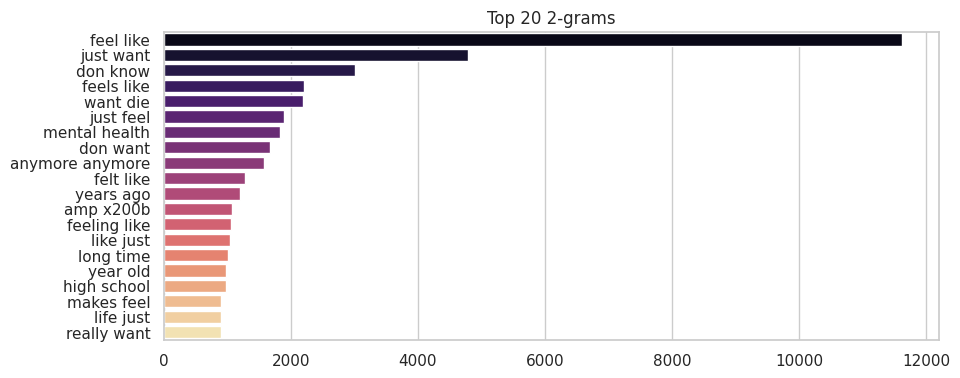

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

def show_top_ngrams(corpus, n=20, ngram_range=(1,1)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus)
    bag = vec.transform(corpus)
    sum_words = bag.sum(axis=0)
    freqs = [(w, sum_words[0, i]) for w, i in vec.vocabulary_.items()]
    freqs = sorted(freqs, key=lambda x: x[1], reverse=True)[:n]
    words = [w for w, _ in freqs]
    counts = [c for _, c in freqs]
    plt.figure(figsize=(10,4))
    sns.barplot(x=counts, y=words, palette='magma')
    plt.title(f"Top {n} {ngram_range[0]}-grams")
    plt.show()

show_top_ngrams(df['statement'], n=20, ngram_range=(1,1))
show_top_ngrams(df['statement'], n=20, ngram_range=(2,2))


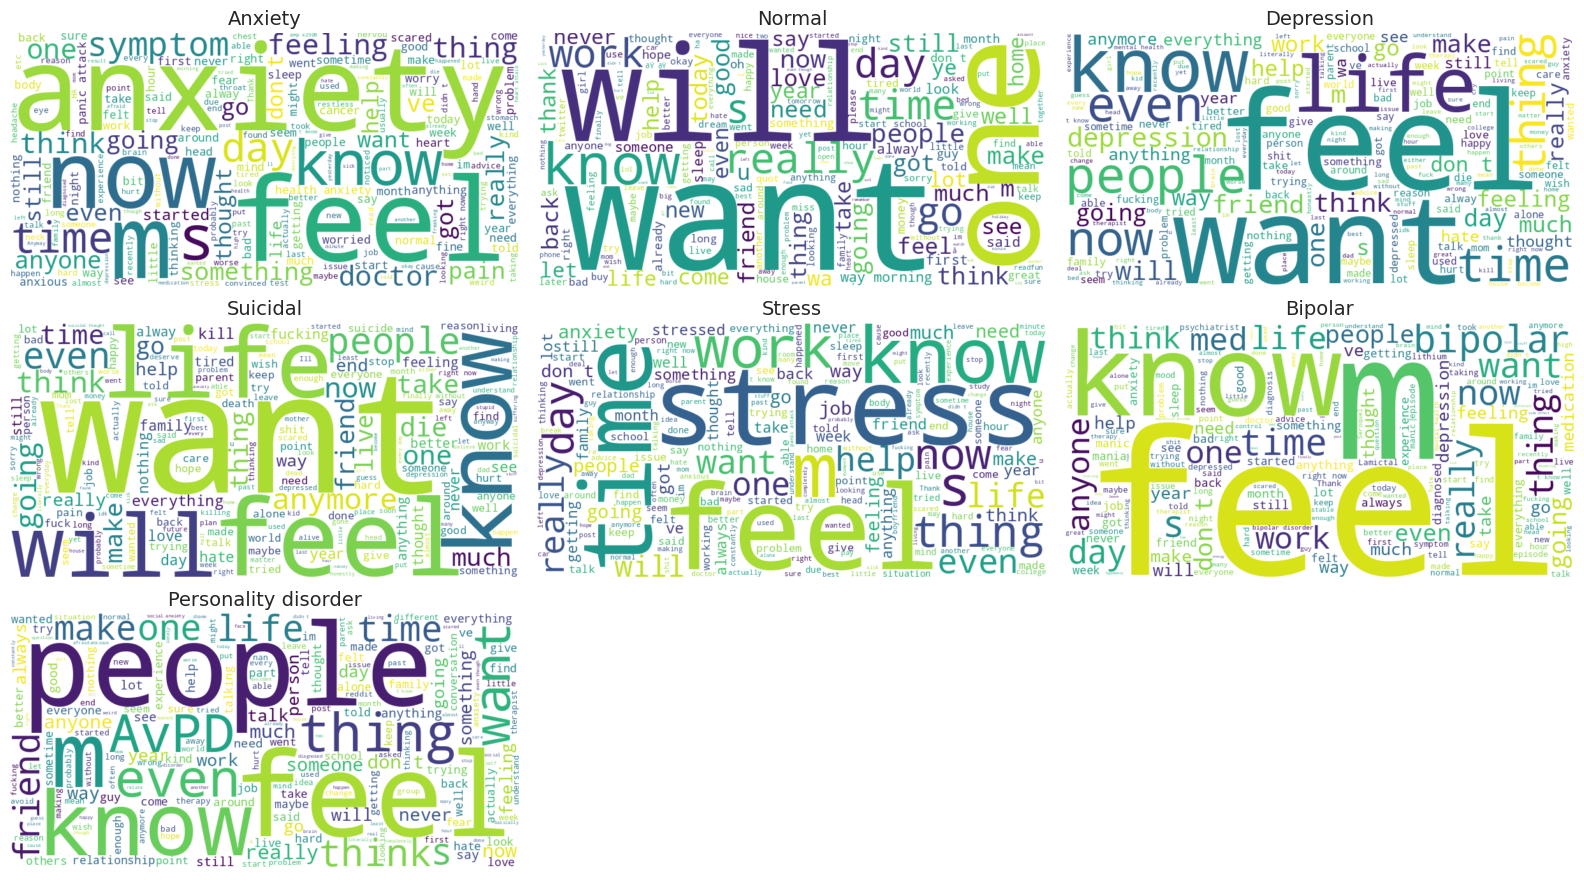

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math

labels = df['status'].unique()
num_labels = len(labels)

# Dynamically set rows and columns
cols = 3
rows = math.ceil(num_labels / cols)

fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
axes = axes.flatten()

for i, label in enumerate(labels):
    text = " ".join(df[df['status'] == label]['statement'].astype(str))
    wc = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(label, fontsize=14)
    axes[i].axis('off')

# Turn off unused subplot boxes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


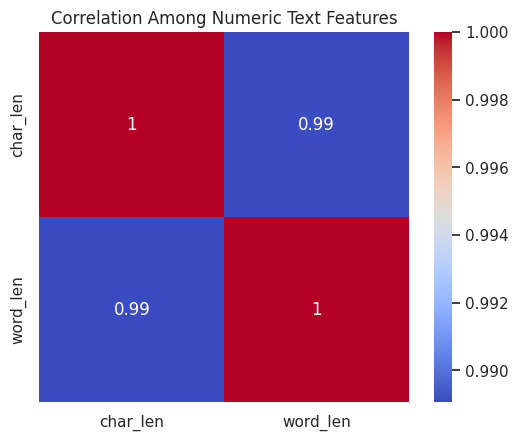

In [31]:
features = ['char_len', 'word_len']
corr = df[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Among Numeric Text Features")
plt.show()


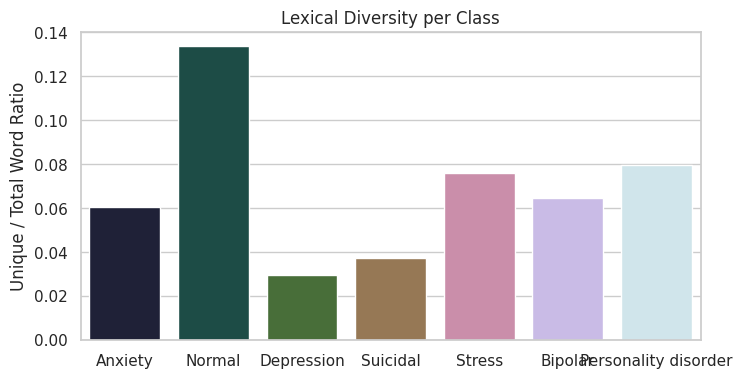

In [32]:
from collections import Counter
def vocab_diversity(texts):
    all_tokens = " ".join(texts).split()
    return len(set(all_tokens)) / len(all_tokens)

diversity = {c: vocab_diversity(df[df['status']==c]['statement']) for c in df['status'].unique()}
plt.figure(figsize=(8,4))
sns.barplot(x=list(diversity.keys()), y=list(diversity.values()), palette='cubehelix')
plt.title("Lexical Diversity per Class")
plt.ylabel("Unique / Total Word Ratio")
plt.show()


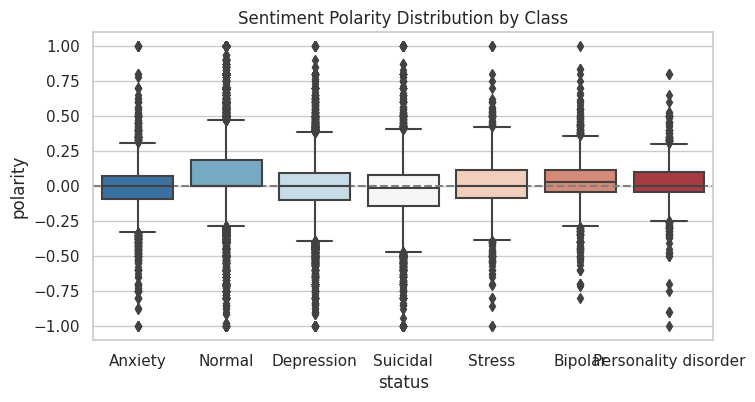

In [33]:
from textblob import TextBlob
df['polarity'] = df['statement'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
plt.figure(figsize=(8,4))
sns.boxplot(x='status', y='polarity', data=df, palette='RdBu_r')
plt.title("Sentiment Polarity Distribution by Class")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


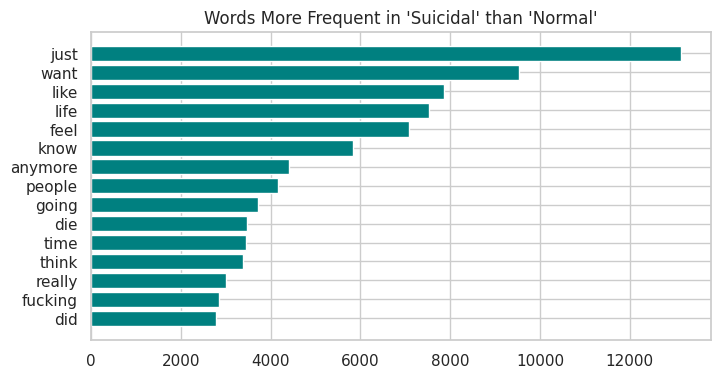

In [34]:
# Compare two classes for discriminative words
def compare_keywords(class_a, class_b, topn=20):
    texts_a = " ".join(df[df['status']==class_a]['statement'])
    texts_b = " ".join(df[df['status']==class_b]['statement'])
    vec = CountVectorizer(stop_words='english', ngram_range=(1,1))
    bag = vec.fit_transform([texts_a, texts_b])
    freqs = np.array(bag.toarray())
    diff = freqs[0] - freqs[1]
    top_words = np.argsort(diff)[-topn:]
    vocab = np.array(vec.get_feature_names_out())
    plt.figure(figsize=(8,4))
    plt.barh(vocab[top_words], diff[top_words], color='teal')
    plt.title(f"Words More Frequent in '{class_a}' than '{class_b}'")
    plt.show()

compare_keywords("Suicidal", "Normal", topn=15)


In [35]:
# Statements with very short or long lengths
short_texts = df[df['word_len'] < 3]
long_texts = df[df['word_len'] > df['word_len'].quantile(0.99)]
print("Very short samples:\n", short_texts.head(5))
print("\nVery long samples:\n", long_texts.head(3))


Very short samples:
         statement   status  num_of_characters  char_len  word_len  polarity
88        Anxious  Anxiety                7.0         7         1     -0.25
284   restless eh  Anxiety               11.0        11         2      0.00
293           nan  Anxiety                NaN         3         1      0.00
303  very nervous  Anxiety               12.0        12         2      0.20
319  Very worried  Anxiety               12.0        12         2      0.20

Very long samples:
                                               statement      status  \
7048  19 years old, male, from the Philippines. The ...  Depression   
7078  First time posting here and feeling a bit ambi...  Depression   
7085  I am sorry if you are already going through so...  Depression   

      num_of_characters  char_len  word_len  polarity  
7048             4691.0      4691       871 -0.122449  
7078             6982.0      6982      1378  0.039078  
7085             4950.0      4950       989  0.00

In [36]:
duplicates = df[df.duplicated(subset=['statement'], keep=False)]
print("Duplicate samples:\n", duplicates.head())
print(f"Duplicate ratio: {len(duplicates)/len(df):.2%}")


Duplicate samples:
                                              statement   status  \
18   "No regrets or grudges/angry at things that ha...  Anxiety   
39   but my heart is still restless even though my ...  Anxiety   
97   "No regrets or grudges/angry at things that ha...  Anxiety   
132  I want to exhale the restlessness in my chest ...  Anxiety   
138  but my heart is still restless even though my ...  Anxiety   

     num_of_characters  char_len  word_len  polarity  
18               123.0       123        20      0.15  
39                62.0        62        12      0.00  
97               123.0       123        20      0.15  
132               60.0        60        12      0.00  
138               62.0        62        12      0.00  
Duplicate ratio: 6.36%


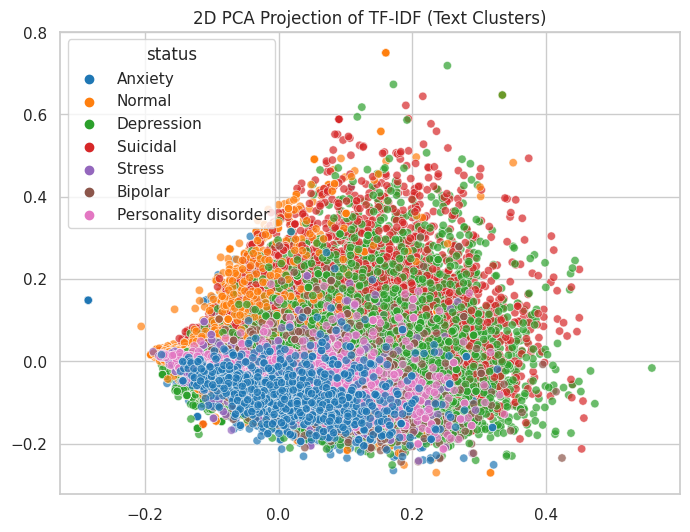

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
X_tfidf = tfidf.fit_transform(df['statement'])
X_pca = PCA(n_components=2, random_state=101).fit_transform(X_tfidf.toarray())
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['status'], palette='tab10', alpha=0.7)
plt.title("2D PCA Projection of TF-IDF (Text Clusters)")
plt.show()


Text Preprocessing

In [38]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)

df['statement']=df['original_statement'].str.lower()
df.head()

original_statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

   num_of_characters  char_len  word_len  polarity  \
0               10.0        10         3    0.0000   
1               64.0        64        10   -0.3000   
2               78.0        78        14   -0.2500   
3               61.0        61        11    0.0000   
4               72.0        72        14   -0.3125   

                                           statement  
0                                         oh my gosh  
1  trouble sleeping, confused mind, restless hear...  
2  all wrong, back off dear, forward doubt. stay ...  
3  i've shifted my focus to something else but i'...  
4  i'm restless and restless, it's been a month n...

In [39]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()

original_statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

   num_of_characters  char_len  word_len  polarity  \
0               10.0        10         3    0.0000   
1               64.0        64        10   -0.3000   
2               78.0        78        14   -0.2500   
3               61.0        61        11    0.0000   
4               72.0        72        14   -0.3125   

                                           statement  
0                                         oh my gosh  
1  trouble sleeping confused mind restless heart ...  
2  all wrong back off dear forward doubt stay in ...  
3  ive shifted my focus to something else but im ...  
4  im restless and restless its been a month now ...

In [40]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

original_statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

   num_of_characters  char_len  word_len  polarity  \
0               10.0        10         3    0.0000   
1               64.0        64        10   -0.3000   
2               78.0        78        14   -0.2500   
3               61.0        61        11    0.0000   
4               72.0        72        14   -0.3125   

                                           statement  \
0                                         oh my gosh   
1  trouble sleeping confused mind restless heart ...   
2  all wrong back off dear forward doubt stay in ...   
3  ive shifted my focus to something else but im ...   
4  im restless and restless its been a month now ...   

                                              tokens  
0                                     [oh, my, gosh]  
1  [trouble, sleeping, confused, mind, restless, ...  
2  [all, wrong, back, off, dear, forward, doubt, ...  
3  [ive, shifted, my, focus, to, something, else,...  
4  [im, restless, and, restless, its, been, a, mo...

In [41]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()

original_statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

   num_of_characters  char_len  word_len  polarity  \
0               10.0        10         3    0.0000   
1               64.0        64        10   -0.3000   
2               78.0        78        14   -0.2500   
3               61.0        61        11    0.0000   
4               72.0        72        14   -0.3125   

                                           statement  \
0                                         oh my gosh   
1  trouble sleeping confused mind restless heart ...   
2  all wrong back off dear forward doubt stay in ...   
3  ive shifted my focus to something else but im ...   
4  im restless and restless its been a month now ...   

                                              tokens  \
0                                     [oh, my, gosh]   
1  [trouble, sleeping, confused, mind, restless, ...   
2  [all, wrong, back, off, dear, forward, doubt, ...   
3  [ive, shifted, my, focus, to, something, else,...   
4  [im, restless, and, restless, its, been, a, mo...   

                                      tokens_stemmed  
0                                         oh my gosh  
1  troubl sleep confus mind restless heart all ou...  
2  all wrong back off dear forward doubt stay in ...  
3  ive shift my focu to someth els but im still w...  
4  im restless and restless it been a month now b...

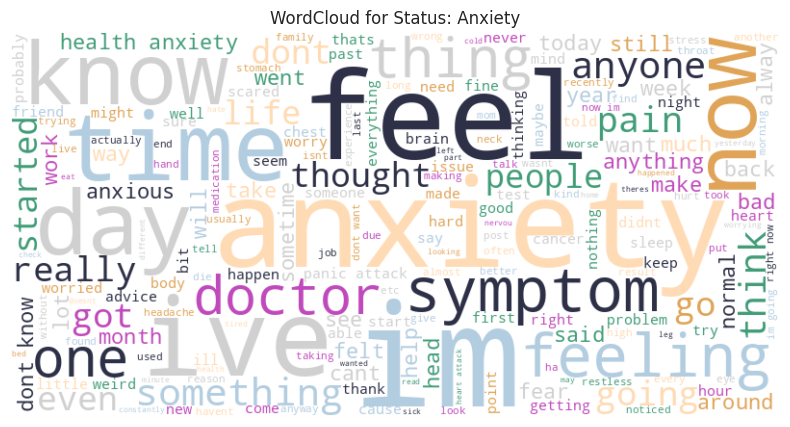

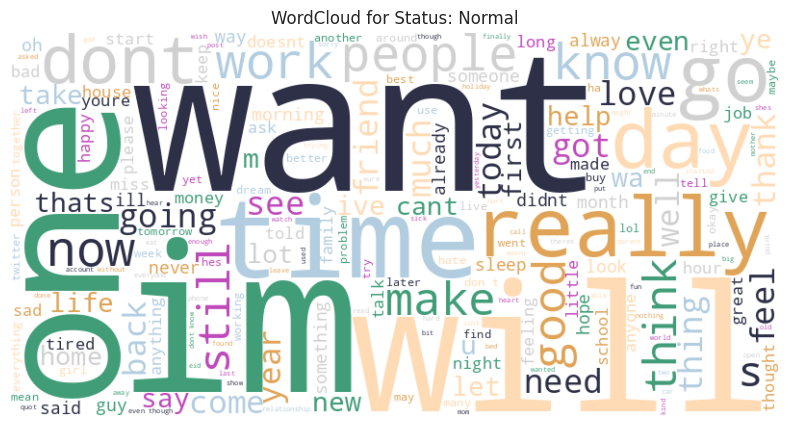

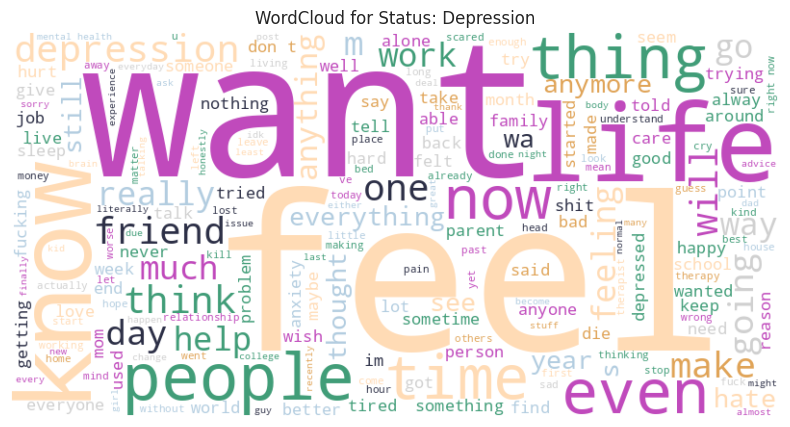

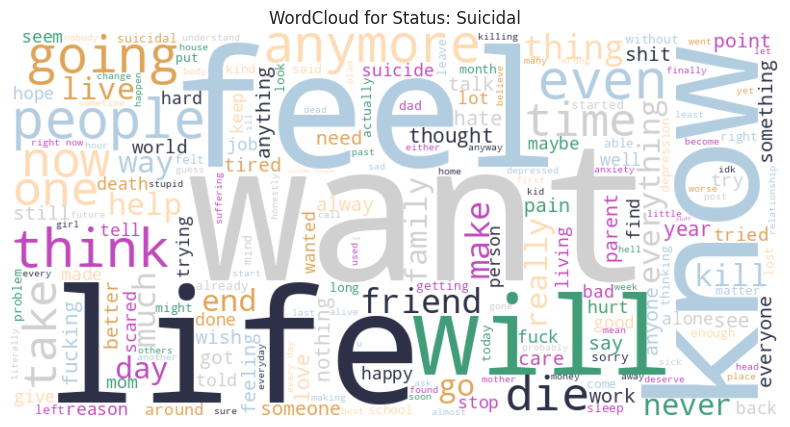

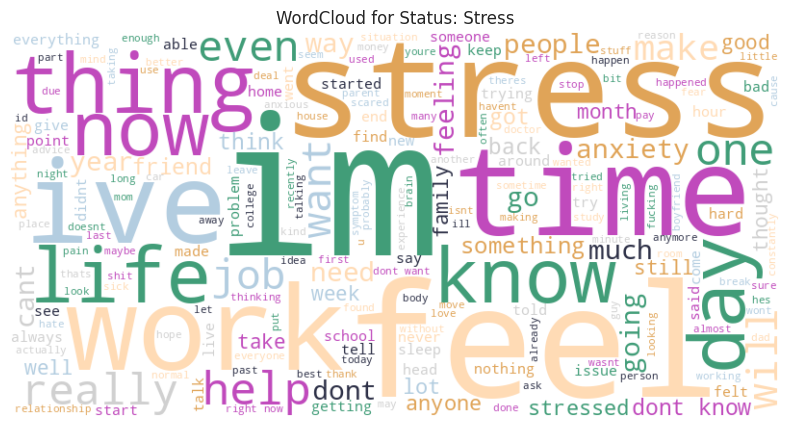

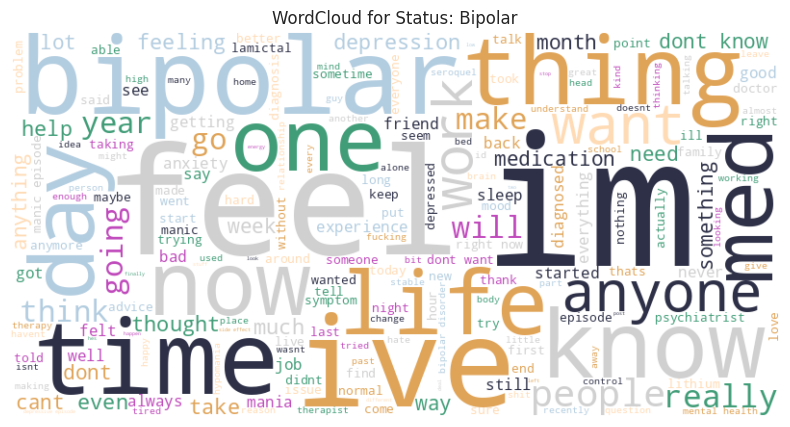

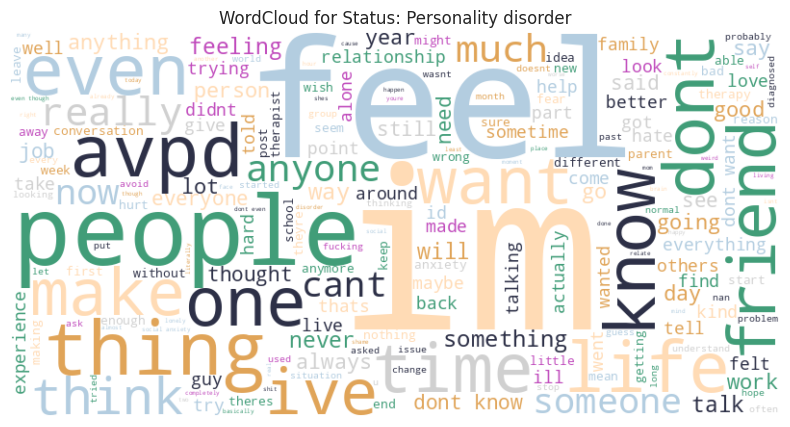

In [42]:
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

Data Preprocessing

In [47]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

In [48]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [50]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [51]:
X_train_combined.shape

(42434, 50002)

In [52]:
# Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

In [53]:
X_train_resampled.shape

(42434, 50002)

Machine learning model run

[WARN] imblearn/RandomOverSampler not available or incompatible.
       Using identity sampler (no oversampling). Details: No module named 'sklearn.utils._metadata_requests'
Resampled training shape: (42434, 50002)
Using XGBoost tree_method: hist

Training Bernoulli Naive Bayes...
Accuracy for Bernoulli Naive Bayes:   0.6355
Macro-F1 for Bernoulli Naive Bayes:   0.5951

                      precision    recall  f1-score   support

             Anxiety       0.69      0.57      0.62       755
             Bipolar       0.69      0.58      0.63       590
          Depression       0.71      0.46      0.56      3128
              Normal       0.66      0.92      0.77      3252
Personality disorder       0.72      0.48      0.58       233
              Stress       0.36      0.61      0.45       519
            Suicidal       0.59      0.52      0.56      2132

            accuracy                           0.64     10609
           macro avg       0.63      0.59      0.60     10609
     

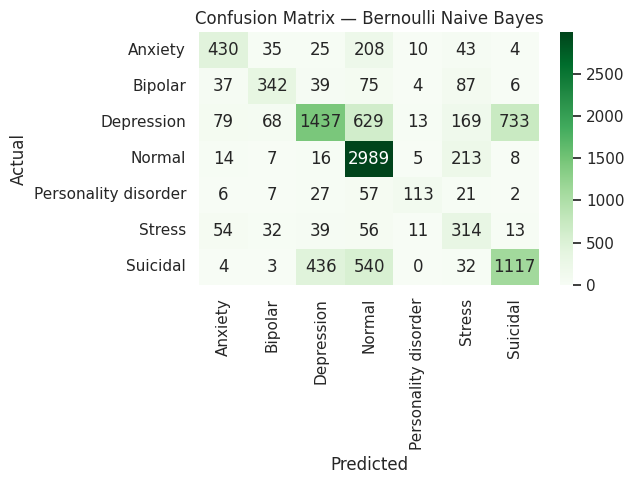


Training Multinomial Naive Bayes...
Accuracy for Multinomial Naive Bayes:   0.6908
Macro-F1 for Multinomial Naive Bayes:   0.5757

                      precision    recall  f1-score   support

             Anxiety       0.70      0.61      0.65       755
             Bipolar       0.79      0.52      0.63       590
          Depression       0.60      0.68      0.64      3128
              Normal       0.78      0.91      0.84      3252
Personality disorder       1.00      0.11      0.20       233
              Stress       0.62      0.35      0.45       519
            Suicidal       0.66      0.58      0.62      2132

            accuracy                           0.69     10609
           macro avg       0.74      0.54      0.58     10609
        weighted avg       0.70      0.69      0.68     10609



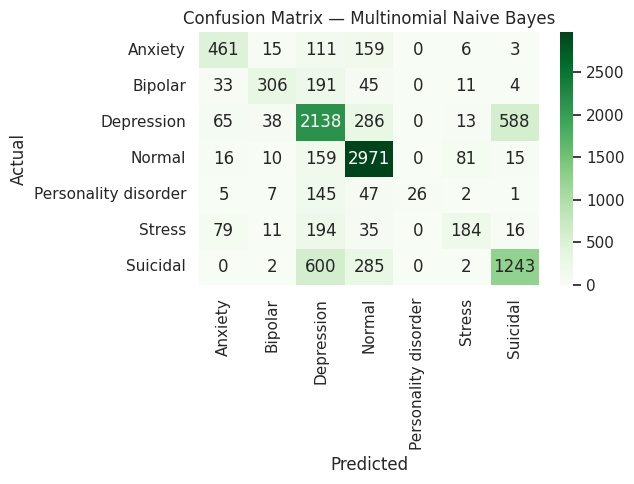


Training Logistic Regression (L1)...
Accuracy for Logistic Regression (L1):   0.7715
Macro-F1 for Logistic Regression (L1):   0.7466

                      precision    recall  f1-score   support

             Anxiety       0.80      0.80      0.80       755
             Bipolar       0.82      0.78      0.80       590
          Depression       0.73      0.69      0.71      3128
              Normal       0.90      0.93      0.92      3252
Personality disorder       0.67      0.77      0.72       233
              Stress       0.59      0.65      0.62       519
            Suicidal       0.66      0.66      0.66      2132

            accuracy                           0.77     10609
           macro avg       0.74      0.76      0.75     10609
        weighted avg       0.77      0.77      0.77     10609



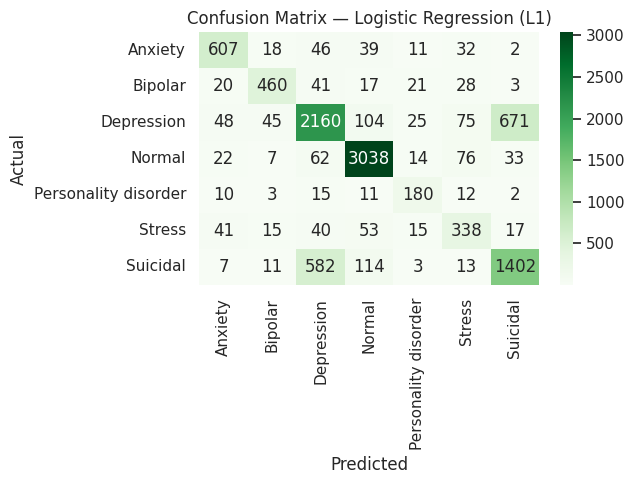


Training SGD (Log Loss)...
Accuracy for SGD (Log Loss):   0.4310
Macro-F1 for SGD (Log Loss):   0.1670

                      precision    recall  f1-score   support

             Anxiety       0.00      0.00      0.00       755
             Bipolar       0.00      0.00      0.00       590
          Depression       0.00      0.00      0.00      3128
              Normal       0.69      0.90      0.78      3252
Personality disorder       0.00      0.00      0.00       233
              Stress       0.00      0.00      0.00       519
            Suicidal       0.26      0.77      0.39      2132

            accuracy                           0.43     10609
           macro avg       0.14      0.24      0.17     10609
        weighted avg       0.26      0.43      0.32     10609



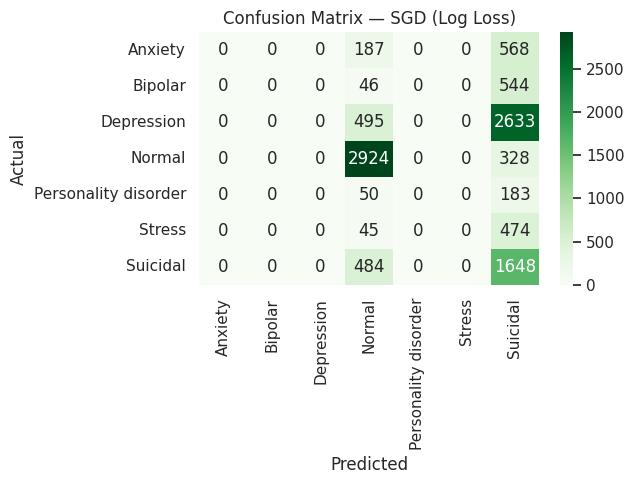


Training Decision Tree...
Accuracy for Decision Tree:   0.6753
Macro-F1 for Decision Tree:   0.5648

                      precision    recall  f1-score   support

             Anxiety       0.44      0.69      0.54       755
             Bipolar       0.90      0.40      0.56       590
          Depression       0.70      0.63      0.66      3128
              Normal       0.76      0.93      0.83      3252
Personality disorder       0.66      0.30      0.41       233
              Stress       0.57      0.27      0.37       519
            Suicidal       0.60      0.56      0.58      2132

            accuracy                           0.68     10609
           macro avg       0.66      0.54      0.56     10609
        weighted avg       0.68      0.68      0.66     10609



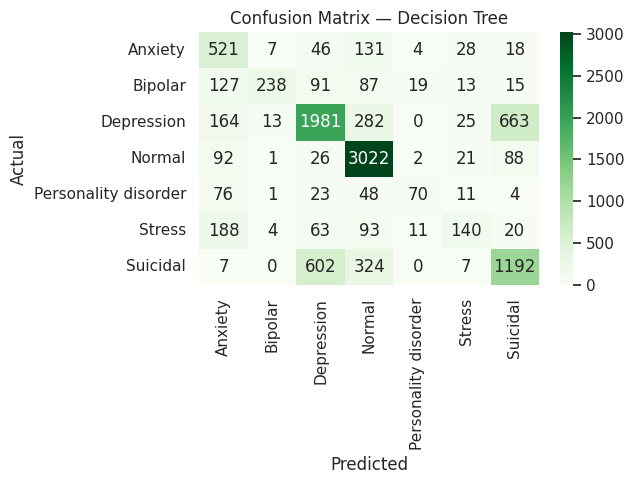


Training Random Forest...
Accuracy for Random Forest:   0.7491
Macro-F1 for Random Forest:   0.7117

                      precision    recall  f1-score   support

             Anxiety       0.75      0.77      0.76       755
             Bipolar       0.86      0.73      0.79       590
          Depression       0.72      0.68      0.70      3128
              Normal       0.85      0.92      0.88      3252
Personality disorder       0.77      0.52      0.62       233
              Stress       0.55      0.61      0.58       519
            Suicidal       0.66      0.64      0.65      2132

            accuracy                           0.75     10609
           macro avg       0.74      0.70      0.71     10609
        weighted avg       0.75      0.75      0.75     10609



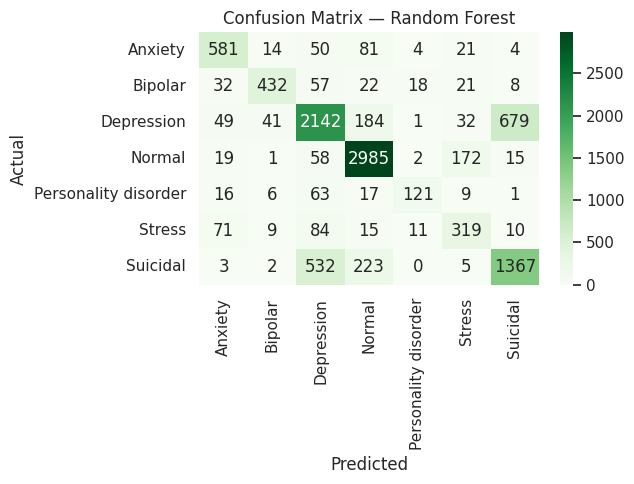


Training Extra Trees...
Accuracy for Extra Trees:   0.7586
Macro-F1 for Extra Trees:   0.7269

                      precision    recall  f1-score   support

             Anxiety       0.76      0.85      0.80       755
             Bipolar       0.85      0.75      0.80       590
          Depression       0.72      0.65      0.68      3128
              Normal       0.88      0.92      0.90      3252
Personality disorder       0.76      0.54      0.63       233
              Stress       0.60      0.60      0.60       519
            Suicidal       0.64      0.71      0.68      2132

            accuracy                           0.76     10609
           macro avg       0.75      0.72      0.73     10609
        weighted avg       0.76      0.76      0.76     10609



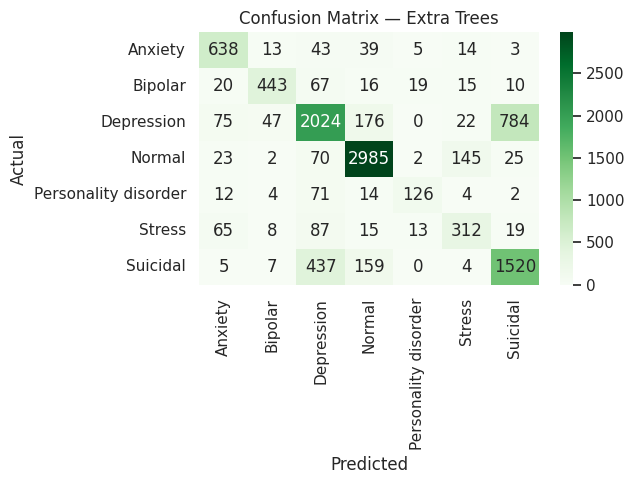


Training Gradient Boosting...
Accuracy for Gradient Boosting:   0.7698
Macro-F1 for Gradient Boosting:   0.7268

                      precision    recall  f1-score   support

             Anxiety       0.80      0.75      0.78       755
             Bipolar       0.92      0.68      0.78       590
          Depression       0.71      0.75      0.73      3128
              Normal       0.86      0.95      0.90      3252
Personality disorder       0.71      0.62      0.67       233
              Stress       0.63      0.52      0.57       519
            Suicidal       0.70      0.63      0.66      2132

            accuracy                           0.77     10609
           macro avg       0.76      0.70      0.73     10609
        weighted avg       0.77      0.77      0.77     10609



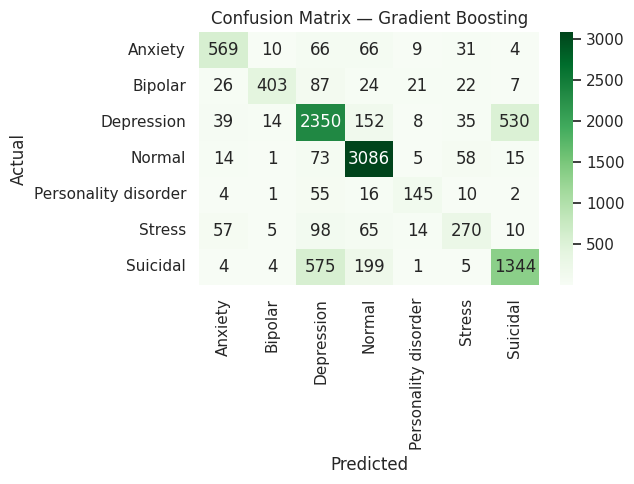


Training XGBoost...
Accuracy for XGBoost:   0.7989
Macro-F1 for XGBoost:   0.7732

                      precision    recall  f1-score   support

             Anxiety       0.83      0.82      0.82       755
             Bipolar       0.91      0.75      0.82       590
          Depression       0.74      0.76      0.75      3128
              Normal       0.91      0.95      0.93      3252
Personality disorder       0.77      0.69      0.72       233
              Stress       0.71      0.64      0.67       519
            Suicidal       0.70      0.68      0.69      2132

            accuracy                           0.80     10609
           macro avg       0.79      0.76      0.77     10609
        weighted avg       0.80      0.80      0.80     10609



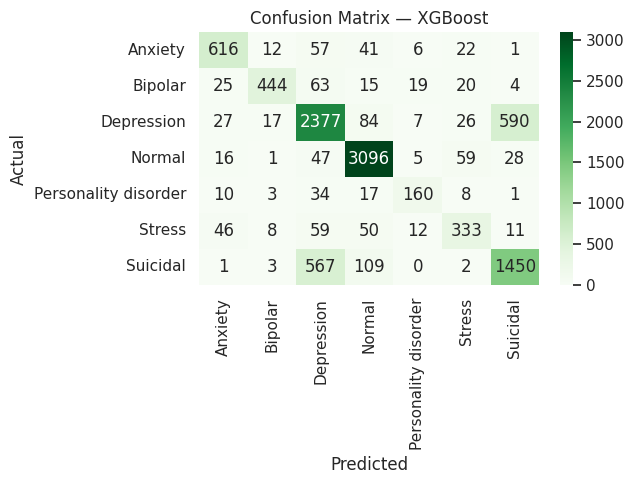


Training LinearSVC (Calibrated)...
Accuracy for LinearSVC (Calibrated):   0.6117
Macro-F1 for LinearSVC (Calibrated):   0.3503

                      precision    recall  f1-score   support

             Anxiety       0.68      0.45      0.54       755
             Bipolar       0.28      0.04      0.06       590
          Depression       0.47      0.85      0.60      3128
              Normal       0.80      0.92      0.86      3252
Personality disorder       1.00      0.02      0.03       233
              Stress       0.44      0.01      0.02       519
            Suicidal       0.76      0.22      0.34      2132

            accuracy                           0.61     10609
           macro avg       0.63      0.36      0.35     10609
        weighted avg       0.64      0.61      0.55     10609



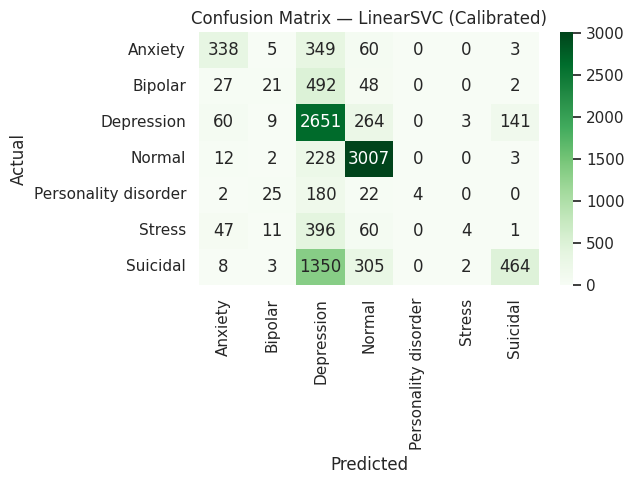

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Soft Voting Ensemble
Accuracy:  0.7934
Macro-F1:  0.7694

                      precision    recall  f1-score   support

             Anxiety       0.83      0.83      0.83       755
             Bipolar       0.94      0.73      0.82       590
          Depression       0.72      0.77      0.75      3128
              Normal       0.88      0.95      0.92      3252
Personality disorder       0.81      0.67      0.73       233
              Stress       0.76      0.59      0.66       519
            Suicidal       0.71      0.64      0.68      2132

            accuracy                           0.79     10609
           macro avg       0.81      0.74      0.77     10609
        weighted avg       0.79      0.79      0.79     10609



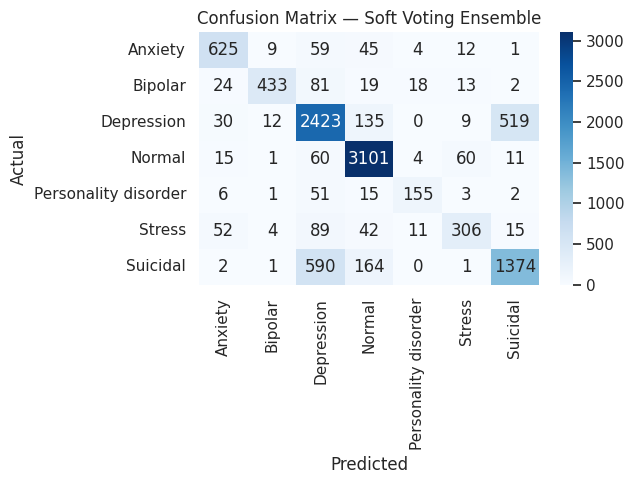

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w


Stacking Ensemble
Accuracy:  0.7887
Macro-F1:  0.7611

                      precision    recall  f1-score   support

             Anxiety       0.83      0.84      0.84       755
             Bipolar       0.82      0.82      0.82       590
          Depression       0.81      0.67      0.73      3128
              Normal       0.94      0.90      0.92      3252
Personality disorder       0.58      0.84      0.69       233
              Stress       0.50      0.82      0.62       519
            Suicidal       0.68      0.75      0.71      2132

            accuracy                           0.79     10609
           macro avg       0.74      0.81      0.76     10609
        weighted avg       0.80      0.79      0.79     10609



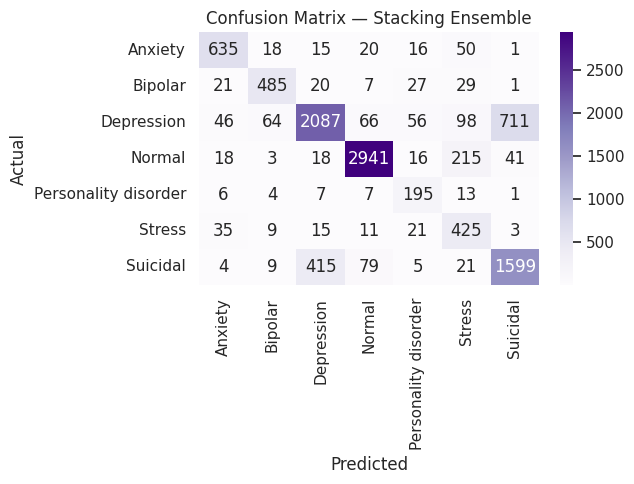


=== Model Performance Summary (sorted by Macro-F1) ===
                   Model  Accuracy  Macro_F1
                 XGBoost  0.798944  0.773189
    Soft Voting Ensemble  0.793383  0.769392
       Stacking Ensemble  0.788670  0.761083
Logistic Regression (L1)  0.771515  0.746591
             Extra Trees  0.758601  0.726946
       Gradient Boosting  0.769818  0.726847
           Random Forest  0.749081  0.711701
   Bernoulli Naive Bayes  0.635498  0.595064
 Multinomial Naive Bayes  0.690829  0.575678
           Decision Tree  0.675276  0.564770
  LinearSVC (Calibrated)  0.611650  0.350339
          SGD (Log Loss)  0.430955  0.166973


In [45]:
# ============================================
# Classical ML & Ensembles — Aligned Template
# ============================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report
)
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier,
    VotingClassifier, StackingClassifier
)
from sklearn.linear_model import SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
# from imblearn.over_sampling import RandomOverSampler

from sklearn.utils.class_weight import compute_class_weight

# Safe import for RandomOverSampler
try:
    from imblearn.over_sampling import RandomOverSampler
    _IMB_OK = True
except Exception as e:
    print("[WARN] imblearn/RandomOverSampler not available or incompatible.")
    print("       Using identity sampler (no oversampling). Details:", e)
    _IMB_OK = False

    # Fallback "do nothing" sampler – keeps your pipeline running
    class RandomOverSampler:
        def __init__(self, *args, **kwargs):
            pass

        def fit_resample(self, X, y):
            # Simply return original data if oversampling is not possible
            return X, y


# Optional (XGBoost)
import xgboost as xgb
from xgboost import XGBClassifier

SEED = 101
np.random.seed(SEED)

# ===============================
# 1. Handle class imbalance
# ===============================
ros = RandomOverSampler(random_state=SEED)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)
print("Resampled training shape:", X_train_resampled.shape)

# ===============================
# 2. Choose tree method dynamically (XGBoost)
# ===============================
try:
    # Prefer the official CUDA check if available
    has_gpu = hasattr(xgb, "cuda") and xgb.cuda.is_available()
    tree_method = 'gpu_hist' if has_gpu else 'hist'
except Exception:
    tree_method = 'hist'
print(f"Using XGBoost tree_method: {tree_method}")

# ===============================
# 3. Define classifiers
# ===============================
# Class weights for linear models (helps on imbalanced sets even after ROS)
classes = np.unique(y_train_resampled)
cw_vals = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_resampled)
class_weight = {int(c): float(w) for c, w in zip(classes, cw_vals)}

classifiers = {
    # Naive Bayes family
    'Bernoulli Naive Bayes': BernoulliNB(alpha=0.1, binarize=0.0),
    'Multinomial Naive Bayes': MultinomialNB(alpha=0.2),

    # Linear baselines
    'Logistic Regression (L1)': LogisticRegression(
        solver='liblinear', penalty='l1', C=10, class_weight=class_weight,
        random_state=SEED, max_iter=2000
    ),
    'SGD (Log Loss)': SGDClassifier(
        loss='log_loss', alpha=1e-5, penalty='l2', class_weight=class_weight,
        random_state=SEED, max_iter=2000, tol=1e-3
    ),

    # Trees / Ensembles
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=SEED),
    'Random Forest': RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_leaf=2,
        class_weight=class_weight, n_jobs=-1, random_state=SEED
    ),
    'Extra Trees': ExtraTreesClassifier(
        n_estimators=500, max_depth=None, min_samples_leaf=2,
        class_weight=class_weight, n_jobs=-1, random_state=SEED
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        learning_rate=0.05, n_estimators=300, subsample=0.9, random_state=SEED
    ),

    # XGBoost
    'XGBoost': XGBClassifier(
        learning_rate=0.2, max_depth=7, n_estimators=500, subsample=0.9,
        colsample_bytree=0.8, reg_lambda=1.0, random_state=SEED,
        tree_method=tree_method, use_label_encoder=False, eval_metric='mlogloss'
    ),

    # Linear SVM (calibrated for probabilities so it can join soft voting)
    'LinearSVC (Calibrated)': CalibratedClassifierCV(
        estimator=LinearSVC(C=1.0, class_weight=class_weight, random_state=SEED),
        method='sigmoid', cv=3
    ),
}

# ===============================
# 4. Train and evaluate classifiers
# ===============================
results = []  # (name, acc, macro_f1)

labels = lbl_enc.classes_
for name, clf in classifiers.items():
    print("\n==============================")
    print(f"Training {name}...")
    print("==============================")

    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test_combined)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy for {name}:   {acc:.4f}")
    print(f"Macro-F1 for {name}:   {macro_f1:.4f}\n")
    print(classification_report(y_test, y_pred, target_names=labels))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6.5,5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title(f'Confusion Matrix — {name}')
    plt.tight_layout(); plt.show()

    results.append((name, acc, macro_f1))

# ===============================
# 5. Soft-Voting Ensemble (probability-based)
# ===============================
# Build voters that support predict_proba (Calibrated SVC already does).
def ensure_proba_model(model):
    if hasattr(model, "predict_proba"):
        return model
    return CalibratedClassifierCV(estimator=model, method='sigmoid', cv=3)

voter_list = []
for vote_name in ['Logistic Regression (L1)', 'LinearSVC (Calibrated)', 'XGBoost', 'Multinomial Naive Bayes']:
    model = classifiers[vote_name]
    model = ensure_proba_model(model)
    model.fit(X_train_resampled, y_train_resampled)
    voter_list.append((vote_name, model))

soft_vote = VotingClassifier(estimators=voter_list, voting='soft', n_jobs=-1, flatten_transform=True)
soft_vote.fit(X_train_resampled, y_train_resampled)
y_pred_sv = soft_vote.predict(X_test_combined)

acc_sv = accuracy_score(y_test, y_pred_sv)
macro_f1_sv = f1_score(y_test, y_pred_sv, average='macro')

print("\n==============================")
print("Soft Voting Ensemble")
print("==============================")
print(f"Accuracy:  {acc_sv:.4f}")
print(f"Macro-F1:  {macro_f1_sv:.4f}\n")
print(classification_report(y_test, y_pred_sv, target_names=labels))

cm_sv = confusion_matrix(y_test, y_pred_sv)
plt.figure(figsize=(6.5,5))
sns.heatmap(cm_sv, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix — Soft Voting Ensemble')
plt.tight_layout(); plt.show()

results.append(("Soft Voting Ensemble", acc_sv, macro_f1_sv))

# ===============================
# 6. Stacking Ensemble (meta-learner = Logistic Regression)
# ===============================
stack_estimators = []
for base_name in ['Logistic Regression (L1)', 'LinearSVC (Calibrated)', 'XGBoost', 'Random Forest']:
    base_model = classifiers[base_name]
    base_model = ensure_proba_model(base_model)
    stack_estimators.append((base_name, base_model))

meta = LogisticRegression(C=2.0, max_iter=2000, class_weight=class_weight, random_state=SEED)
stack = StackingClassifier(
    estimators=stack_estimators,
    final_estimator=meta,
    stack_method='predict_proba',
    n_jobs=-1
)
stack.fit(X_train_resampled, y_train_resampled)
y_pred_stack = stack.predict(X_test_combined)

acc_stack = accuracy_score(y_test, y_pred_stack)
macro_f1_stack = f1_score(y_test, y_pred_stack, average='macro')

print("\n==============================")
print("Stacking Ensemble")
print("==============================")
print(f"Accuracy:  {acc_stack:.4f}")
print(f"Macro-F1:  {macro_f1_stack:.4f}\n")
print(classification_report(y_test, y_pred_stack, target_names=labels))

cm_stack = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(6.5,5))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Purples',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix — Stacking Ensemble')
plt.tight_layout(); plt.show()

results.append(("Stacking Ensemble", acc_stack, macro_f1_stack))

# ===============================
# 7. Summary of results
# ===============================
print("\n=== Model Performance Summary (sorted by Macro-F1) ===")
summary_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Macro_F1']).sort_values('Macro_F1', ascending=False)
print(summary_df.to_string(index=False))


Deep learning model Implementation

Using existing LabelEncoder.
Classes: ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']
Chosen max_len: 500
Vocab size (capped): 67769
Class weights: {0: 1.9491961414790997, 1: 2.633362293657689, 2: 0.49192566745110766, 3: 0.4634202278113294, 4: 6.308012486992716, 5: 2.839344262295082, 6: 0.711335367284675}

Training CNN_1D...
Epoch 1/20


I0000 00:00:1763874694.572013      86 service.cc:148] XLA service 0x7ec4f40154a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763874694.573803      86 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763874694.573827      86 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763874695.064406      86 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/597 ━━━━━━━━━━━━━━━━━━━━ 1:29:03 9s/step - accuracy: 0.1406 - loss: 1.8217

I0000 00:00:1763874700.859118      86 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


597/597 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.4160 - loss: 1.6639 - val_accuracy: 0.7066 - val_loss: 0.7788 - learning_rate: 0.0010
Epoch 2/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.6920 - loss: 0.8904 - val_accuracy: 0.7408 - val_loss: 0.6556 - learning_rate: 0.0010
Epoch 3/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.7624 - loss: 0.6264 - val_accuracy: 0.7630 - val_loss: 0.6603 - learning_rate: 0.0010
Epoch 4/20
596/597 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7959 - loss: 0.5007
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
597/597 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.7959 - loss: 0.5006 - val_accuracy: 0.7590 - val_loss: 0.6889 - learning_rate: 0.0010
Epoch 5/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.8411 - loss: 0.3489 - val_accuracy: 0.7719 - val_loss: 0.6937 - learning_rate: 5.0000e-04
Epoch 6/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8759 - loss: 0.272

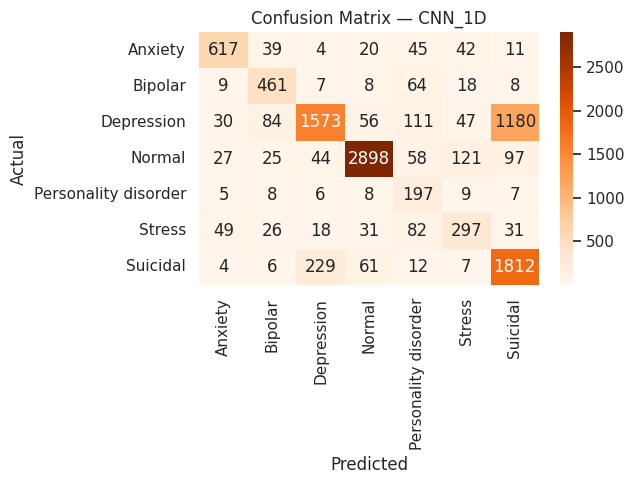


Training BiLSTM...
Epoch 1/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 2903s 5s/step - accuracy: 0.4473 - loss: 1.6945 - val_accuracy: 0.5761 - val_loss: 0.9935 - learning_rate: 0.0010
Epoch 2/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 2877s 5s/step - accuracy: 0.5876 - loss: 1.1380 - val_accuracy: 0.6237 - val_loss: 0.8333 - learning_rate: 0.0010
Epoch 3/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 2871s 5s/step - accuracy: 0.6437 - loss: 0.8579 - val_accuracy: 0.6277 - val_loss: 0.8620 - learning_rate: 0.0010
Epoch 4/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 2858s 5s/step - accuracy: 0.6893 - loss: 0.6657 - val_accuracy: 0.6350 - val_loss: 0.8199 - learning_rate: 0.0010
Epoch 5/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 2846s 5s/step - accuracy: 0.7032 - loss: 0.5874 - val_accuracy: 0.6659 - val_loss: 0.8041 - learning_rate: 0.0010
Epoch 6/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 2846s 5s/step - accuracy: 0.7409 - loss: 0.4761 - val_accuracy: 0.6998 - val_loss: 0.7879 - learning_rate: 0.0010
Epoch 7/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 2895s 5s/step - 

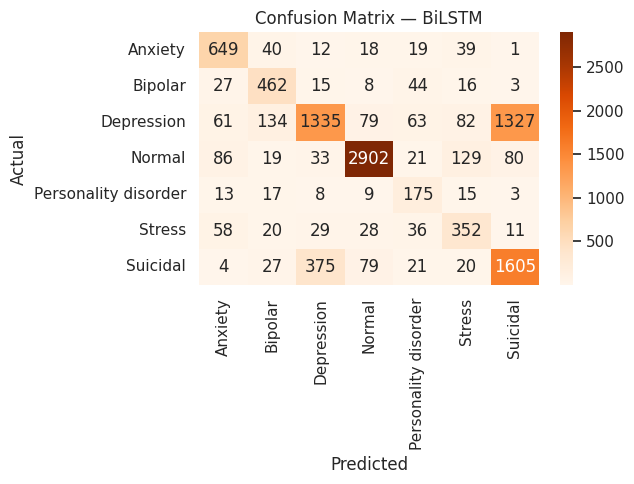


Training BiGRU...
Epoch 1/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 2538s 4s/step - accuracy: 0.4040 - loss: 1.7047 - val_accuracy: 0.6378 - val_loss: 0.8501 - learning_rate: 0.0010
Epoch 2/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 2517s 4s/step - accuracy: 0.6455 - loss: 0.9265 - val_accuracy: 0.6751 - val_loss: 0.8047 - learning_rate: 0.0010
Epoch 3/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 2507s 4s/step - accuracy: 0.7225 - loss: 0.6607 - val_accuracy: 0.7387 - val_loss: 0.6999 - learning_rate: 0.0010
Epoch 4/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 2522s 4s/step - accuracy: 0.7873 - loss: 0.5032 - val_accuracy: 0.7387 - val_loss: 0.7420 - learning_rate: 0.0010
Epoch 5/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8346 - loss: 0.3797
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
597/597 ━━━━━━━━━━━━━━━━━━━━ 2514s 4s/step - accuracy: 0.8346 - loss: 0.3797 - val_accuracy: 0.7427 - val_loss: 0.7960 - learning_rate: 0.0010
Epoch 6/20
140/597 ━━━━━━━━━━━━━━━━━━━━ 31:17 4s/step - accur

In [ ]:
# ============================================
# Deep Learning Models (CNN, LSTM, GRU, Hybrid)
# ============================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sns.set(style="whitegrid")

SEED = 101
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ===============================
# 1. Prepare labels & encoder
# ===============================
assert 'statement' in df.columns and 'status' in df.columns, "df must have 'statement' and 'status'"

texts = df['statement'].astype(str).fillna("")

# Use existing lbl_enc if available; otherwise create a new one
try:
    lbl_enc
    print("Using existing LabelEncoder.")
    y = lbl_enc.transform(df['status'].values)
except NameError:
    print("Creating new LabelEncoder.")
    lbl_enc = LabelEncoder()
    y = lbl_enc.fit_transform(df['status'].values)

num_classes = len(lbl_enc.classes_)
print("Classes:", lbl_enc.classes_)

# Split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, y, test_size=0.20, stratify=y, random_state=SEED
)

# ===============================
# 2. Tokenize & pad sequences
# ===============================
max_vocab = 100_000
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=max_vocab, oov_token=oov_token)
tokenizer.fit_on_texts(X_train_text.tolist())

X_train_seq = tokenizer.texts_to_sequences(X_train_text.tolist())
X_test_seq  = tokenizer.texts_to_sequences(X_test_text .tolist())

lengths = np.array([len(s) for s in X_train_seq if len(s) > 0] + [1])
max_len = int(min(500, np.percentile(lengths, 98)))  # long enough for context
max_len = max(max_len, 60)  # floor
print("Chosen max_len:", max_len)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_len, padding='post', truncating='post')

vocab_size = min(max_vocab, len(tokenizer.word_index) + 1)
print("Vocab size (capped):", vocab_size)

# ===============================
# 3. Class weights (for imbalance)
# ===============================
classes = np.unique(y_train)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}
print("Class weights:", class_weight)

# ===============================
# 4. Model builder functions
# ===============================
embedding_dim = 256
l2_reg = 1e-4
drop_embed = 0.25
drop_dense = 0.5

def build_cnn_model():
    inp = layers.Input(shape=(max_len,), name="input_ids")
    x = layers.Embedding(vocab_size, embedding_dim, input_length=max_len, name="embedding")(inp)
    x = layers.SpatialDropout1D(drop_embed)(x)

    # Multi-kernel CNN (3,4,5,7)
    def conv_block(x, k, filters=256):
        y = layers.Conv1D(filters, k, padding='same', activation='relu')(x)
        return y

    c3 = conv_block(x, 3); p3 = layers.GlobalMaxPooling1D()(c3)
    c4 = conv_block(x, 4); p4 = layers.GlobalMaxPooling1D()(c4)
    c5 = conv_block(x, 5); p5 = layers.GlobalMaxPooling1D()(c5)
    c7 = conv_block(x, 7); p7 = layers.GlobalMaxPooling1D()(c7)

    x = layers.Concatenate()([p3, p4, p5, p7])
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(drop_dense)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(drop_dense)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inp, out, name="CNN_Text")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_bilstm_model():
    inp = layers.Input(shape=(max_len,), name="input_ids")
    x = layers.Embedding(vocab_size, embedding_dim, input_length=max_len, name="embedding")(inp)
    x = layers.SpatialDropout1D(drop_embed)(x)

    x = layers.Bidirectional(layers.LSTM(192, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(drop_dense)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(drop_dense)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inp, out, name="BiLSTM_Text")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_bigru_model():
    inp = layers.Input(shape=(max_len,), name="input_ids")
    x = layers.Embedding(vocab_size, embedding_dim, input_length=max_len, name="embedding")(inp)
    x = layers.SpatialDropout1D(drop_embed)(x)

    x = layers.Bidirectional(layers.GRU(192, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    x = layers.Bidirectional(layers.GRU(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(drop_dense)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(drop_dense)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inp, out, name="BiGRU_Text")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_cnn_bilstm_model():
    """Hybrid CNN + BiLSTM"""
    inp = layers.Input(shape=(max_len,), name="input_ids")
    x = layers.Embedding(vocab_size, embedding_dim, input_length=max_len, name="embedding")(inp)
    x = layers.SpatialDropout1D(drop_embed)(x)

    # CNN feature extractor
    c = layers.Conv1D(256, 5, padding='same', activation='relu')(x)
    c = layers.MaxPooling1D(pool_size=2)(c)

    # BiLSTM on top
    x = layers.Bidirectional(layers.LSTM(192, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(c)
    x = layers.GlobalMaxPooling1D()(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(drop_dense)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(drop_dense)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inp, out, name="CNN_BiLSTM_Text")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Dictionary of model builders
deep_model_builders = {
    "CNN_1D": build_cnn_model,
    "BiLSTM": build_bilstm_model,
    "BiGRU": build_bigru_model,
    "CNN_BiLSTM": build_cnn_bilstm_model,
}

# ===============================
# 5. Train & evaluate each model
# ===============================
results_dl = []  # (name, accuracy, macro_f1)
histories = {}

for name, builder in deep_model_builders.items():
    print("\n==============================")
    print(f"Training {name}...")
    print("==============================")

    model = builder()

    es = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    ckpt = callbacks.ModelCheckpoint(f"{name}_best.keras", monitor='val_loss', save_best_only=True, verbose=0)
    rlrop = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1)

    history = model.fit(
        X_train_pad, y_train,
        validation_split=0.1,
        epochs=20,
        batch_size=64,
        class_weight=class_weight,
        callbacks=[es, ckpt, rlrop],
        verbose=1
    )
    histories[name] = history.history

    # Load best weights
    best_model = tf.keras.models.load_model(f"{name}_best.keras")
    y_prob = best_model.predict(X_test_pad, batch_size=256, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    print(f"\n{name} - Accuracy:  {acc:.4f}")
    print(f"{name} - Macro-F1:  {macro_f1:.4f}\n")
    print(classification_report(y_test, y_pred, target_names=lbl_enc.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6.5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()

    # Save metrics
    results_dl.append((name, acc, macro_f1))

# ===============================
# 6. Summary of deep model results
# ===============================
print("\n=== Deep Learning Models Performance Summary (sorted by Macro-F1) ===")
summary_dl = pd.DataFrame(results_dl, columns=['Model', 'Accuracy', 'Macro_F1']).sort_values('Macro_F1', ascending=False)
print(summary_dl.to_string(index=False))
